<a href="https://colab.research.google.com/github/pschorey/Valpo_IT533/blob/main/02_Pedagogy_Regression_and_Simple_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pedagogy Lab 02 (Regression and Simple Classification)

This is a continuation of Pedagogy Lab 01 which can be found here: 

https://colab.research.google.com/drive/1Gos-qDcRW845Mh8sQTiLeaK4pCiMfFmx?usp=sharing 



In [23]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

steam = pd.read_csv("https://raw.githubusercontent.com/pschorey/Valpo_IT533/main/steam_games_short.csv")
#print(steam.head())
#print(steam.dtypes)
#print(steam.describe())

In [24]:
#prepare the data

#add rating categories
bins = [0, 2, 3, 4]
labels = ['Bad', 'Average', 'Good', 'Excellent']
d = dict(enumerate(labels, 1))
steam['Rating_Labels'] = np.vectorize(d.get)(np.digitize(steam['Avg_Rating_5'], bins))
#above code from https://stackoverflow.com/questions/49382207/how-to-map-numeric-data-into-categories-bins-in-pandas-dataframe 


#add numeric data for owner estimates of the games (change owners from strings to ints)
steam['Owners_Copy'] = steam['Owners'].str.replace(',','')  #get rid of commans, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html
ownersCopy = steam['Owners_Copy'].str.split(pat=' .. ', n=0, expand=True) #remove text separater, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html
steam['Owners_Min'] = pd.to_numeric(ownersCopy[0]) #convert string to int, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html
steam['Owners_Max'] = pd.to_numeric(ownersCopy[1])
steam['Owners_Mid'] = (steam['Owners_Min'] + steam['Owners_Max']) / 2


#drop redundant or useless columns
steam = steam.drop(columns=['AppID', 'Owners', 'Owners_Copy'])

                         Positive_Reviews  Negative_Reviews  Price_USD  \
Positive_Reviews                 1.000000          0.943765   0.047186   
Negative_Reviews                 0.943765          1.000000   0.046559   
Price_USD                        0.047186          0.046559   1.000000   
Initial_Price_USD                0.048736          0.047102   0.978121   
Discount_Percent                -0.003501         -0.005421  -0.133566   
Peak_Concurrent_Players          0.839230          0.883512   0.011412   
Required_Age                     0.066672          0.067917   0.126125   
Avg_Rating_5                     0.004725          0.005802  -0.006667   
Playability_Index_10            -0.004120         -0.000769   0.008147   
Owners_Min                       0.556687          0.607095   0.034124   
Owners_Max                       0.520433          0.577402   0.030183   
Owners_Mid                       0.531386          0.586473   0.031356   

                         Initial_Pric

<Axes: >

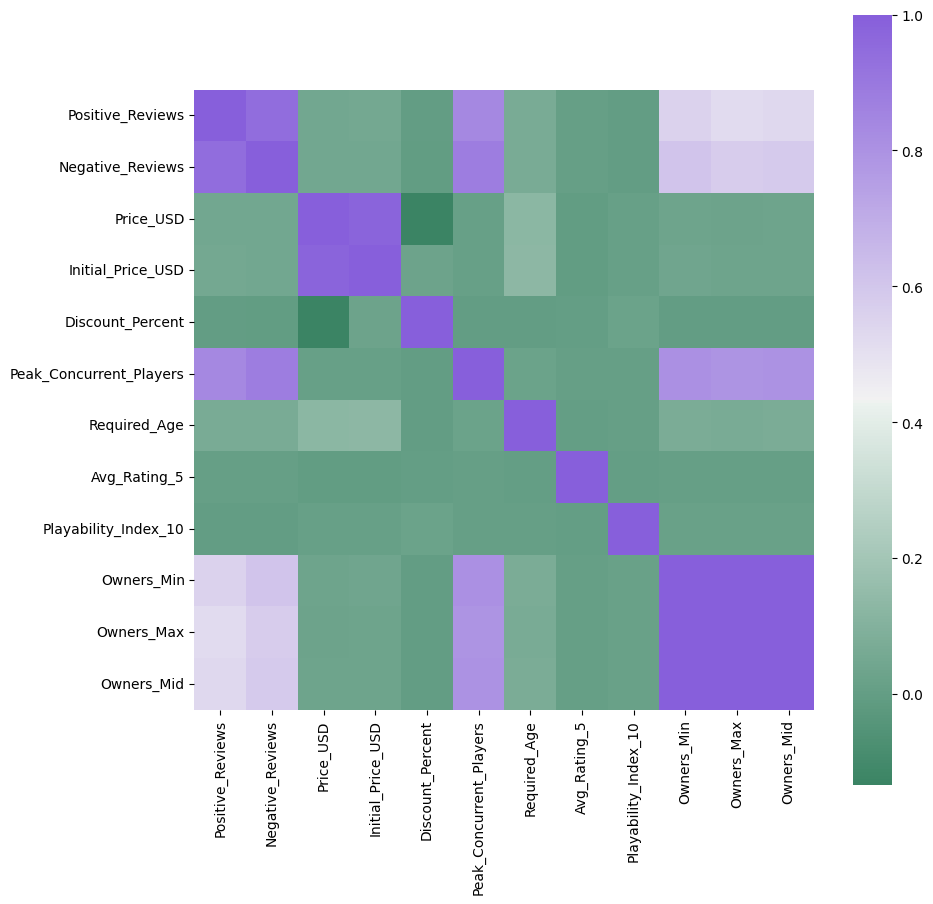

In [25]:
#correlations
corr = steam.corr(numeric_only=True)
print(corr)


#heatmap
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = bool), 
            cmap = sns.diverging_palette(150, 275, as_cmap = True), square = True, ax = ax)

To my surprise there seems to be some correlation between price and required age, and positive / negative reviews and age, let's look into that data a little more


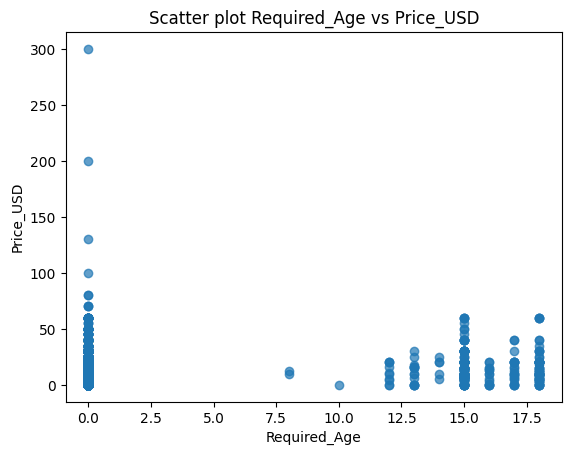

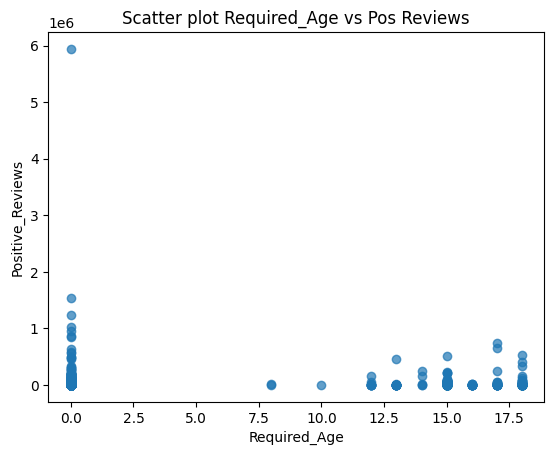

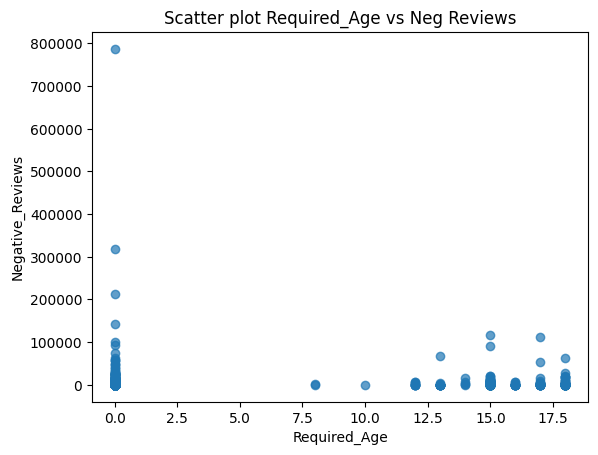

In [21]:
#age / price
plt.scatter(steam['Required_Age'], steam['Price_USD'], alpha=.7)
plt.title('Scatter plot Required_Age vs Price_USD')
plt.xlabel('Required_Age')
plt.ylabel('Price_USD')
plt.show()

#age / positive reviews
plt.scatter(steam['Required_Age'], steam['Positive_Reviews'], alpha=.7)
plt.title('Scatter plot Required_Age vs Pos Reviews')
plt.xlabel('Required_Age')
plt.ylabel('Positive_Reviews')
plt.show()

#age / negative reviews
plt.scatter(steam['Required_Age'], steam['Negative_Reviews'], alpha=.7)
plt.title('Scatter plot Required_Age vs Neg Reviews')
plt.xlabel('Required_Age')
plt.ylabel('Negative_Reviews')
plt.show()

In [26]:
X = steam['Required_Age']
y = steam['Price_USD']
X = sm.add_constant(X) #stats module

## sm.OLS(output, i.e. dependent variable, input, i.e. independent variable)
steam.mod1 = sm.OLS(y, X).fit()  #OLS = ordinary least squares
steam.mod1_summary = steam.mod1.summary()
print(steam.mod1_summary)

                            OLS Regression Results                            
Dep. Variable:              Price_USD   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     179.8
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.10e-40
Time:                        04:00:04   Log-Likelihood:                -40417.
No. Observations:               11126   AIC:                         8.084e+04
Df Residuals:                   11124   BIC:                         8.085e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.3660      0.088     95.260   

In [27]:
predictions = steam.mod1.predict(X) # Here, you'll see the CALCULATED values with the formula
predictions

0        8.365959
1        8.365959
2        8.365959
3        8.365959
4        8.365959
           ...   
11121    8.365959
11122    8.365959
11123    8.365959
11124    8.365959
11125    8.365959
Length: 11126, dtype: float64

eval_env: 1


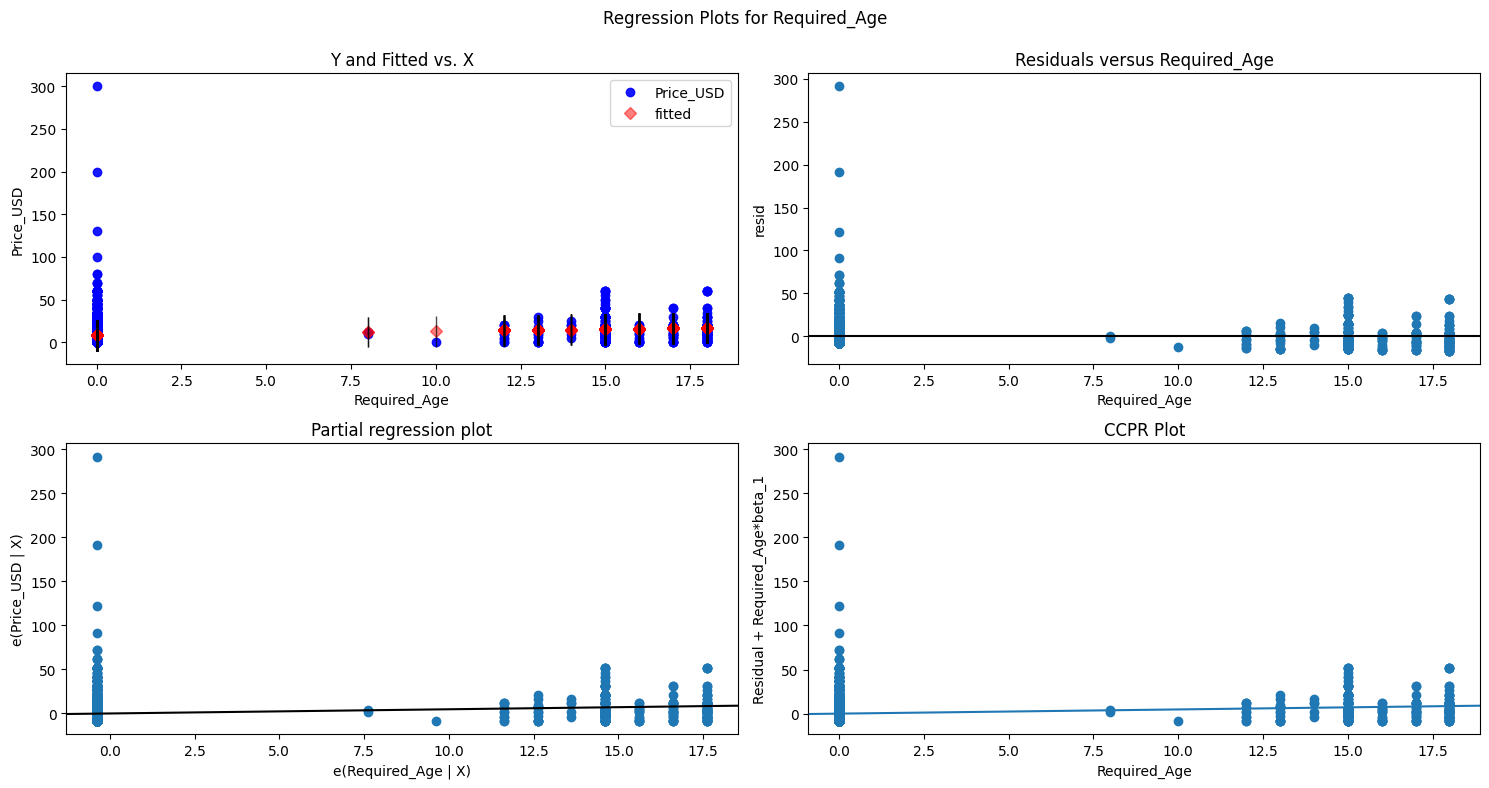

In [29]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(steam.mod1, "Required_Age", fig=fig)

A bit as expected...although there is some correlation between age and game price, our model does a pretty horrible job predicting it!

                            OLS Regression Results                            
Dep. Variable:       Negative_Reviews   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     51.55
Date:                Tue, 30 May 2023   Prob (F-statistic):           7.43e-13
Time:                        04:16:40   Log-Likelihood:            -1.1712e+05
No. Observations:               11126   AIC:                         2.343e+05
Df Residuals:                   11124   BIC:                         2.343e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          558.3207     86.667      6.442   

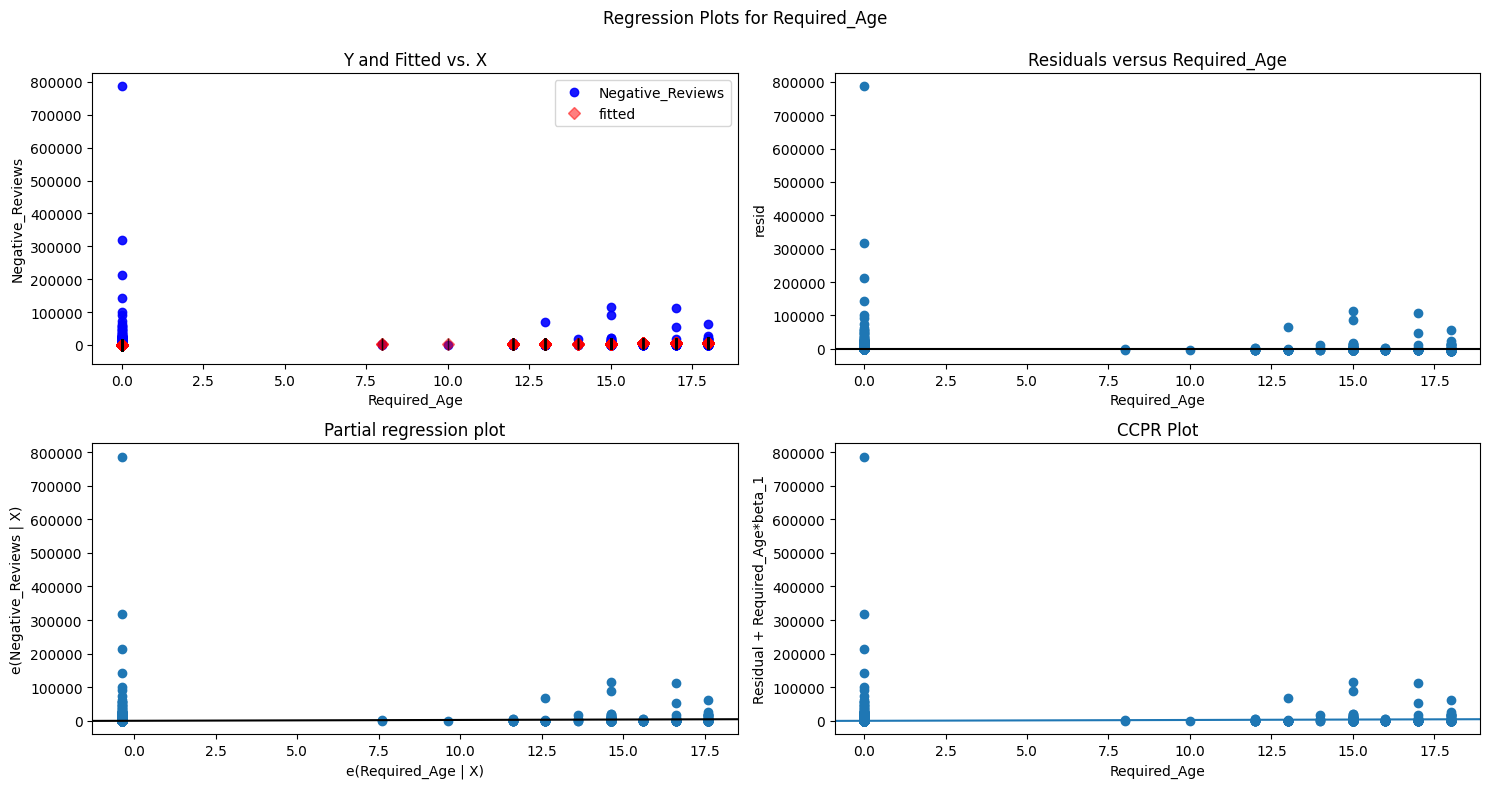

In [32]:
#let's see if people are more negative by age.....
X = steam['Required_Age']
y = steam['Negative_Reviews']
X = sm.add_constant(X)


steam.mod2 = sm.OLS(y, X).fit() 
steam.mod2_summary = steam.mod2.summary()
print(steam.mod1_summary)

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(steam.mod2, "Required_Age", fig=fig)

# Your turn:
Is there another simple linear regression we can try? I was thinking age and pos / neg ratings looked interesting. Give it a shot here:

In [ ]:
steam.groupby(['Genre']).sum()

In [ ]:
steam.groupby(['Genre']).median()